In [36]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pat
import statsmodels.api as sm

Tutorial: https://github.com/ppsp-team/PyNM/blob/master/tutorials/1-getting_started.ipynb

# Centiles and LOESS (Locally Estimated Scatterplot Smoothing) Tutorial


## Normative Modelling Basics

The basic idea of normative modeling is to fit a model on the controls (or a subset of them) of a dataset, and apply it to the rest of the subjects. This trains the model on the normal range, and allows us to use it as a barometer of how far from that range new subjects are by comparing their actual score to what is expected by the model. We can use a variety of models for this task, but a key feature we want from our model is to estimate both the mean and the variance of the predictive distribution. The mean will give us a value to compare our subjects scores to, and the variance will allow us to quantify the normal range of deviations.

## PyNM

To get started using PyNM, all we need is a dataframe with the following columns:

- score: The response variable of interest
- group: A column that indicates probands and controls
- confound(s): The explanatory variable(s)

## Centiles & LOESS

Both the Centiles & LOESS approaches operate by dividing the dataset into bins along the range of a single explanatory variable and estimating a simple model in each bin.
- Centiles fits a linear model in each bin
- LOESS fits a polynomial model in each bin

## Example

### Generate Data
First we generate the data as in Tutorial 0:

- We model score = 2*log(age) + gaussian noise 
- Probands have a random offset to their score
- Probands are not distributed evenly throughout the dataset

In [56]:
# Define functions to simulate data

# Generate n_subs samples drawn uniformly from the interval low, high
# 'full' refers to sampling from one normal distribution, while sampling != 'full' generates form two normal distributions
def sample_x(low=1, high=100, n_subs=1000, sampling = 'full'):
    if sampling == 'full':
        x = np.random.uniform(low = low, high = high, size = n_subs)
    else:

        # The first half of n_subs comes from a normal distribution with a mean of 20 and a sd of 10
        # The second half comes from a normal distribution with a mean of 80 and a sd of 10
        # The two sets are concatenates into one array     
        x = np.concatenate([np.random.normal(20,10,size=int(n_subs/2)), np.random.normal(80,10,size=int(n_subs/2))])
        
        # The final array is filtered to only keep values between low and high
        x = x[(x<high) & (x>low)]
    return x


# Define basic logarithmic function
def f(x):

    # f(x)=2⋅ln(x)+ϵ 
    # Formula of the ln(x) scaled by 2, plus a random noise from a normal distribution with mean 0 and sd 1
    return 2*np.log(x)+np.random.randn()


# Define function to generate dataset
def dataset(seed=10, sampling='full'):
   
    # Set seed of random number, ensures reproducibility, default seed is set at 10
    np.random.seed(seed)

    # Generate age parameter based on sample_x funtion defined earlier
    # Sort the ages in ascending order to help visualisation/analysis
    x = np.sort(sample_x(sampling=sampling))

    # Simulate control and proband status, by having two binary arrays with different probabilities of probands/controls
    # 75% of the data points (status_1) have a 20% probability of being assigned 1 (first 75% of ages have a 20% chance of being Proband)
    # 25% of the data points have a 7% probability of being assigned a 1 (Next 25% of ages have a 7% of being a Proband)
    status_1 = np.random.binomial(1,0.2,size=(int(0.75*x.shape[0]))) #np.random.binomial(n: num of trials, p: prob. of success (0 or 1), size = output shape)
    status_2 = np.random.binomial(1,0.07, size=(x.shape[0]-status_1.shape[0]))
    status = np.concatenate([status_1,status_2])

    # Simulate score parameter

    #Create an empty array of length x.shape[0]
    score = np.zeros(x.shape[0])

    # Loop over each element in the array and calculates a score for the corresponding element x[i]
    for i in range(x.shape[0]):

        # Apply a function f(x) to the i-th element of x
        s = f(x[i])

        # Random offset only for probands not for controls
        # Since status = 1 for probands, a random value drawn from a normal distribution with a mean of 0.7 and sd of 1 is added to the score
        s = s + status[i]*np.random.normal(0.7,1)

        # Assign the calculated score s to the i-th position in the empty score array
        score[i] = s
    
    # Transpose switches the rows and columns so that age, status and score become column names instead of row names
    return pd.DataFrame([x, status, score], index=['age', 'status', 'score']).transpose() 


In [38]:
# Create a dataset
df = dataset()
df.head()

,age,status,score
0,1.174205,0.0,1.733340
1,1.329895,1.0,0.201192
2,1.390878,0.0,2.098539
3,1.418167,0.0,0.034777
4,1.436357,0.0,0.509641


### Visualise data

- Controls = 0
- Probands = 1

Extreme scores for a given age are more frequently probands.

More precisely, remember that:
- The first 75% of all sorted ages have a 20% chance of being a proband 
- The remaining 25% of sorted ages have only a 7% of being a proband (less probands in old people)

<Axes: xlabel='age', ylabel='score'>

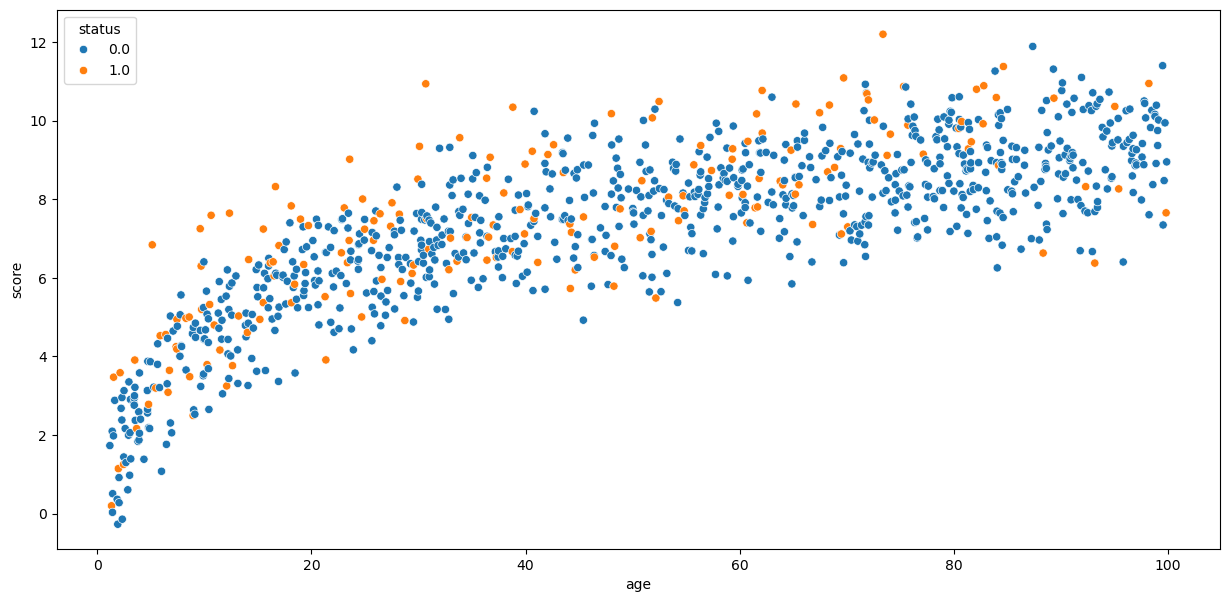

In [39]:
# Plot the data
plt.figure(figsize=(15,7))
sns.scatterplot(x='age', y='score', hue='status', data=df)

### Fit Centiles & LOESS models with default parameters

- First we initialise a PyNM object with our dataset, the columns that indicated the score and the group (PROB/CTR), and the confounds (explanatory variables). 

- Centiles and LOESS only take on a single explanatory variable.

The default parameters for the LOESS and Centiles models give us a rough grained fit to our data by choosing a relatively large bin size and spacing, we can adjust that by specifying the bin size and width directly when we instantiate the PyNM object.

In [40]:
# Initialise pynm object
m = PyNM(df, 'score', 'status', ['age'])

# Run models
m.loess_normative_model()
m.centiles_normative_model()

Models will be fit on full set of controls.


### Interpretation

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$


$$
\text{SMSE} = \frac{MSE}{\sigma^2}
$$ 



Scaled Mean Squared Error (SMSE): metric used to evaluate the performance of a regression model, allows for comparisons between different models or data sets. It is basically a ratio of the Mean Squared Error (MSE) to the variance, hence it can give insight on how much the predicition error relates to the inherent variability in the data:

- **SMSE = 1:** The prediction errors of the model are equal to  the variability in the data, suggesting the model is not better than an average prediction.
- **SMSE < 1:** The prediction errors of the model are smaller than the variability in the data, suggesting the model performs well.
- **SMSE > 1:** The prediction errors of the model are bigger than the variability in the data, suggesting the model performs poorly. 

Hence when comapring models, a lower SMSE indicates a better fit of the model to the data relative to the variance in the data.

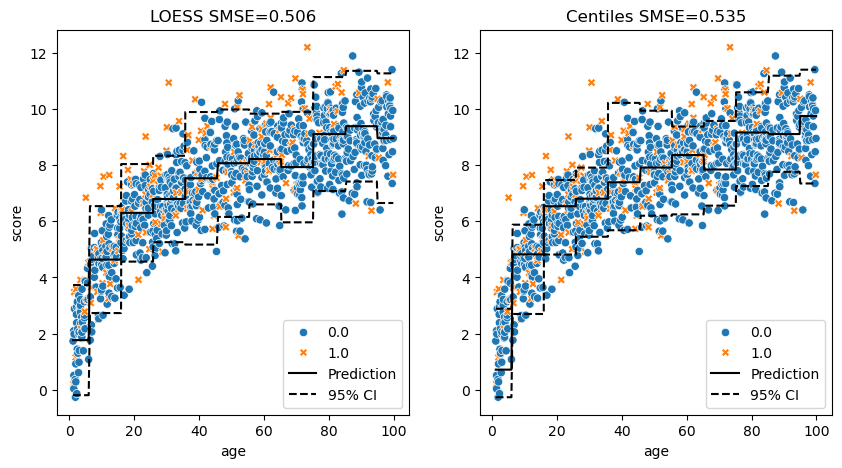

In [41]:
# Plot the data, model predicition and 95% confidence interval
m.plot()

### Interpretation

The **LOESS** function creates "bins" around the predictor variable and performing localized weighted least squares regressions within each bin. This results in the smoothed black line that changes direction in a flexible manner according to the local data. The 95% Confidence intervals are shown in dashed line.


The **Centiles** regression fits percentile (centile) values of the response variable based on covariates like age. It is often used to model conditional quantities, such as 5th, 50th, or 95th percentiles. The 95% Confidence intervals are shown in dashed line.

The LOESS model has a lower SMSE than the Centiles model suggesting it is a better fit for the data.

/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:1047: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])
/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:1047: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])


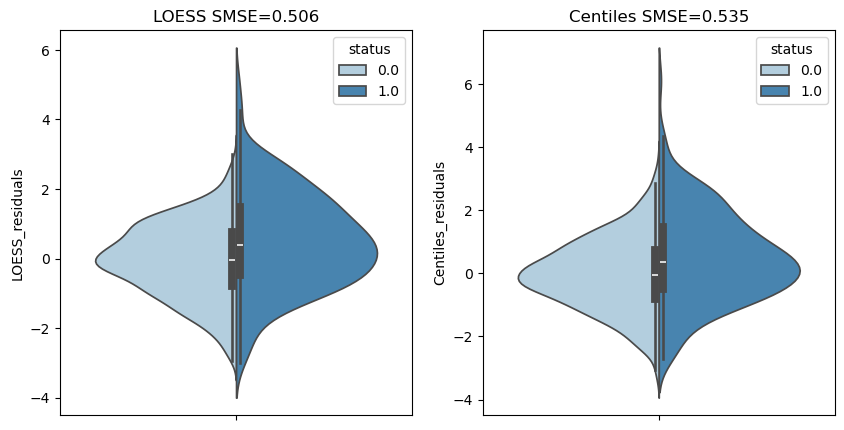

In [42]:
# Plot the residuals of the model (actual value - predicted value)
m.plot_res()

### Interpretation

Plotting residuals means visualising the difference between the observed data points and the model's predicted values.

$$
\text{Residual} = y_{\text{observed}} - y_{\text{predicted}}
$$

### What can you learn from Residual Plots

1. **Model fit:** Residuals should be randomly distributed aroud 0. If they show a clear pattern, this might indicate a model that does not capture the data well (e.g. a non-linear relationship being modeled by a linear model). Could also mean there is heteroscedasticity (non-constant variance of residuals).

2. **Bias in prediction:** If one group (control or probands) has consistently higher or lower residuals, it might suggest that the model is biased towards under-or over-predicting for that group.

3. **Spread of residuals:** A larger variance of the data in one of the groups means that the model's predictions have more variability and may be less reliable.

4. **Outliers:** Extreme residual values indicate outloers, where the model's predicitions deviate significanltu from actual values


Here, the residuals plot look quite good, well spread and seem randomly distributed around 0 for both groups. Probands have a slightly higher residual's average, this could be due to different local patterns in the group as well as different trends in the distribution.


/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:1047: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])
/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:1047: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])


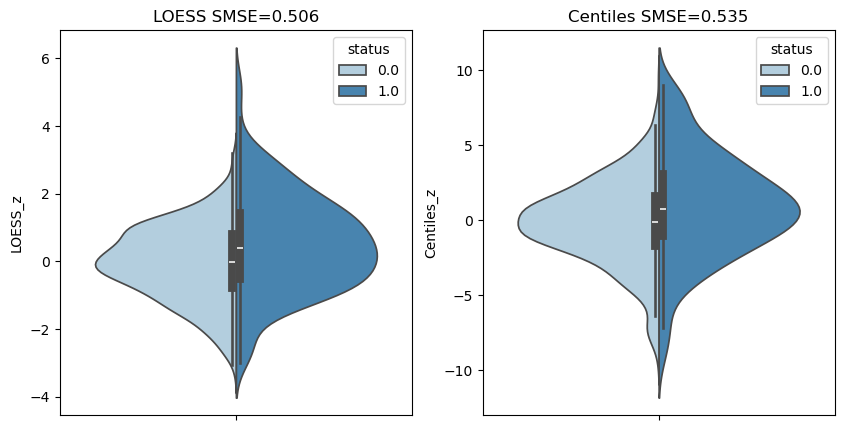

In [43]:
# Plot the z-scores of the model (model residuals / std deviation)
m.plot_z()

### Interpretation

$$
z_{\text{residual}} = \frac{(r_i - \bar{r})}{s}
$$

Where:

- $z_{\text{residual}}$ is the z-score of the residual
- $r_i$ is the ith residual (i.e., the difference between observed and predicted values)
- $\bar{r}$ is the mean of the residuals
- $s$ is the standard deviation of the residuals

Calculating the Z-scores of model residuals is useful to compare different models, as it standardises the residuals. In fact, Z-scores indicate how many standard deviations a particular residual is from the mean. Thsi provides a clear metric for assessing the magnitude of the residuals in relation to the overall distribution of residuals.

- A Z-score greater than 3 or less than -3 is ofte considered an outlier (i.e., residuals that are more than three standard deviations from the mean).

Plotting Z-scores also allows you to assess whether the residuals are normally distributed forming a bell-shape curve if the mdoel is fitetd properly. 

If patterns or systematic deviations can be seen in your data it can signal issues such as:

- Misspecification of the model
- Heteroscedasticity (non-constant variance of residuals)

## Fit Centiles and LOESS models with custom bin parameters

Here we initialize a PyNM object in the same manner as before, but we specify the bin_spacing and bin_width parameters to get a finer grained fit to our data.

In [44]:
# Initialise pynm object with data, confound and bin parameters
# bin_spacing: Distance between bins for LOESS & centiles models
# bin_width: Width of bins for LOESS & centiles models
m_fine = PyNM(df, 'score', 'status', ['age'], bin_spacing=1, bin_width=7)

# Run models
m_fine.loess_normative_model()
m_fine.centiles_normative_model()

Models will be fit on full set of controls.


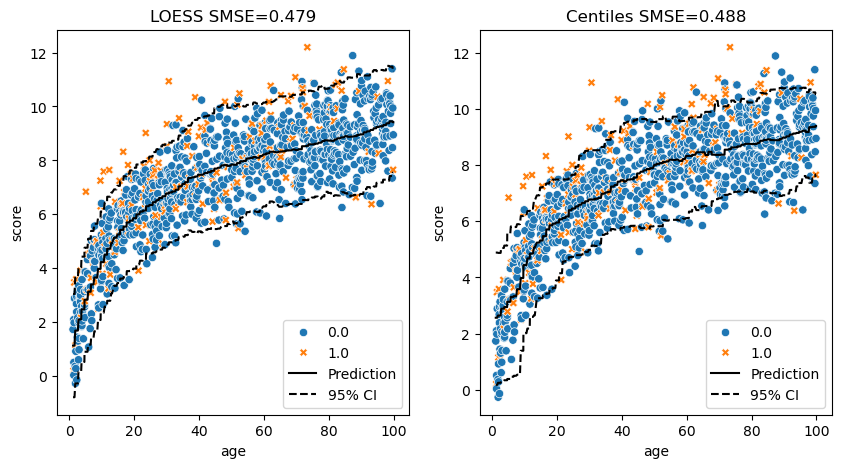

In [45]:
# Plot the data, model prediction, 95% confidence interval
m_fine.plot()

### Interpretation
We can see above that using finer values for bin_spacing and a larger bin_width gives us a smoother fit. Note that increasing bin_width smooths the fit, however it can also include subjects in each bin that have very different scores and resuls in a less optimal loval fit - this can be seen clearly in the younger age range with the centiles model.

- Try to change the values if you want to observe the impact


Furthermore, these parameters seem to be a better fit for the data, with lower SMSE for both the LOESS and Centiles model.

/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:1047: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])
/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:1047: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])


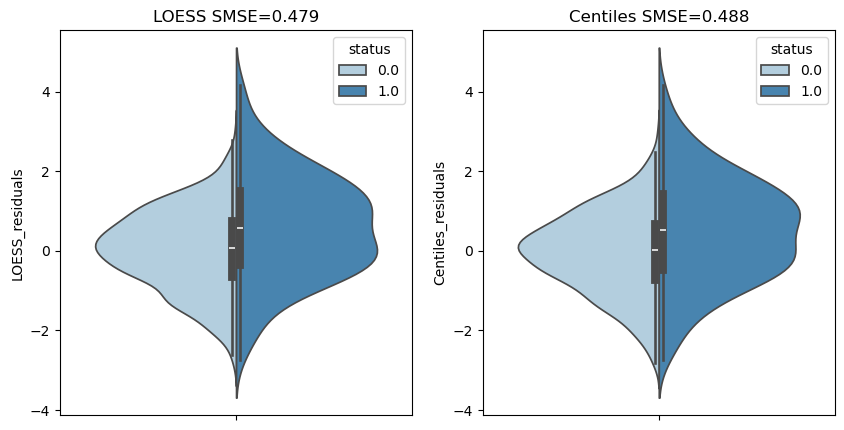

/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:1047: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])
/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:1047: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])


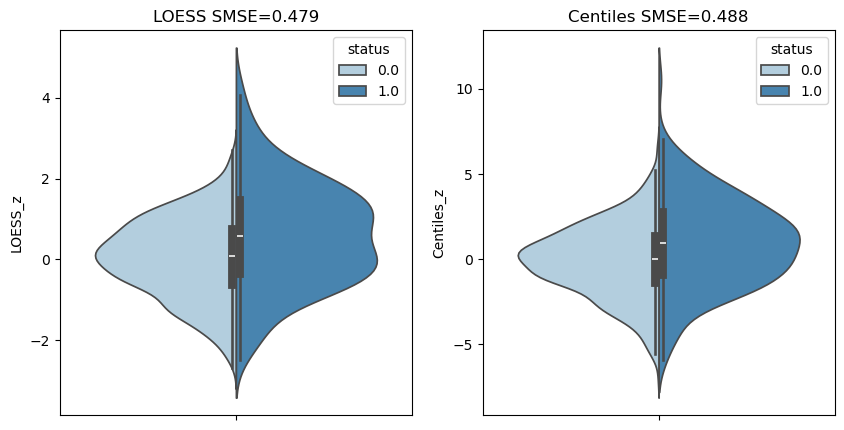

In [46]:
# Plot the residuals of the model (actual value - predicted value)
m_fine.plot_res()

# Plot the z-scores of the model (model residuals / std deviation)
m_fine.plot_z()

### Interpretation

The residuals for both the LOESS and centiles models are more tightly centered around zero in this version of the model compared to the previous one, confirming a more optimal fit.

### Fit Centiles & LOESS models with missing data
One of the main limitations of the Centiles & LOESS models is that they do not handle missing data well. If there is insufficient data in a bin the model won't be run there and we will have gaps in our results, and if there are simply very few data points in a bin the model estimates won't be reliable. We'll look at other models in the next tutorials that address this limitation.

To illustrate this we'll generate the same dataset as above but with a gap in subjects for a given age, then fit the LOESS and Centiles models on it with different values of bin_width and bin_spacing to highlight both issues.

<Axes: xlabel='age', ylabel='score'>

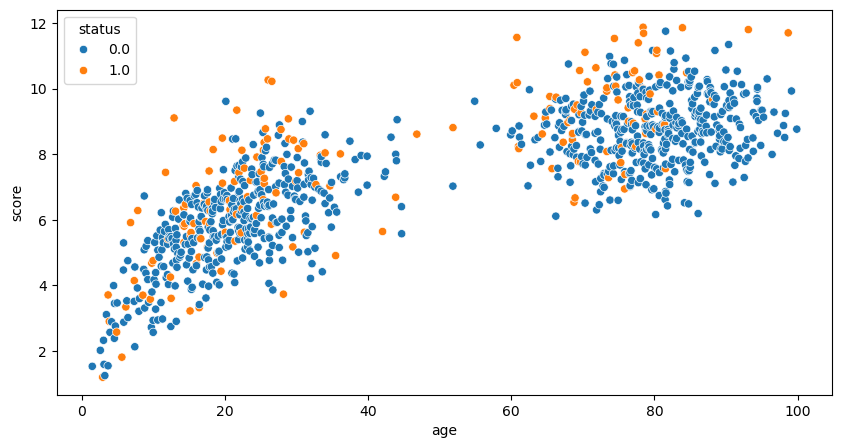

In [57]:
# Create a dataset with a gap
df_gap = dataset(sampling='gap')

# Visualise data
plt.figure(figsize=(10,5))
sns.scatterplot(x='age', y='score', hue='status', data=df_gap)

In [58]:
# Initialise pynm object with data confound and bin parameters
m_gap1 = PyNM(df_gap, 'score', 'status', ['age'], bin_spacing=1, bin_width=7)
m_gap2 = PyNM(df_gap, 'score', 'status', ['age'], bin_spacing=1, bin_width=3)

# Run models
m_gap1.loess_normative_model()
m_gap1.centiles_normative_model()

m_gap2.loess_normative_model()
m_gap2.centiles_normative_model()

Models will be fit on full set of controls.
Models will be fit on full set of controls.


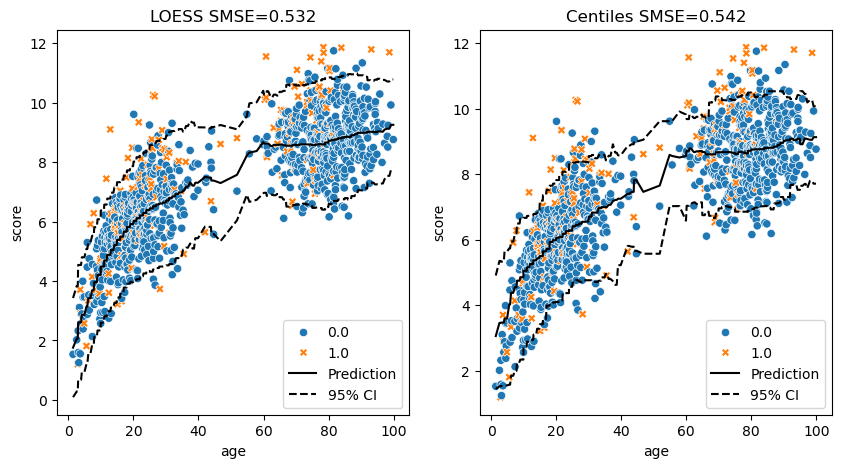

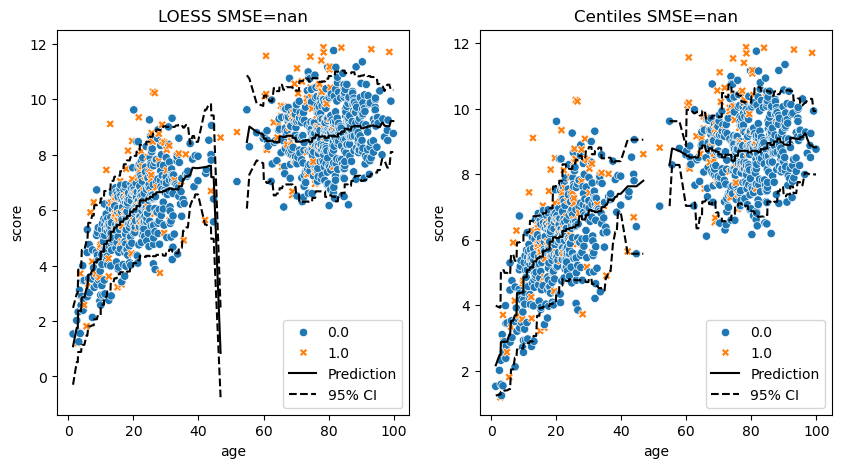

In [59]:
# Plot the data, model prediction and 95% confidence interval
m_gap1.plot()
m_gap2.plot()

### Interpretation

The use of a smaller bin_width causes a worse fit (with the incapacity of calculating the SMSE) for both models. When the data is sparse or unevenly distributed across the age range (which it is here as we have created a gap), some bins may contain very few or no points, leading to unstable/unreliable local fits.

In general though, the gaps in the data are not very well modelled. Furthermore, as visible in the following graphs, the residuals and the Z-scores distribution for the m2_gap LOESS model have positively skewed, suggesting the model tends to underestimate the target values for some of the data points (leaving extra positive residuals). This means that in some cases the model's predicted values are significanlty lower than the actual values. For the centiles model, the residual distribution seems a bit better, although the Z-scores distribution is also positively skewed.

/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:1047: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])
/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:1047: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])


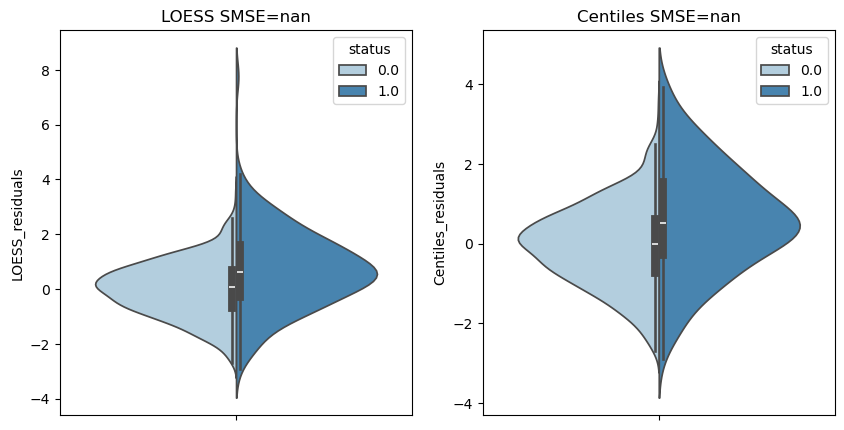

/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:1047: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])
/opt/anaconda3/lib/python3.12/site-packages/pynm/pynm.py:1047: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])


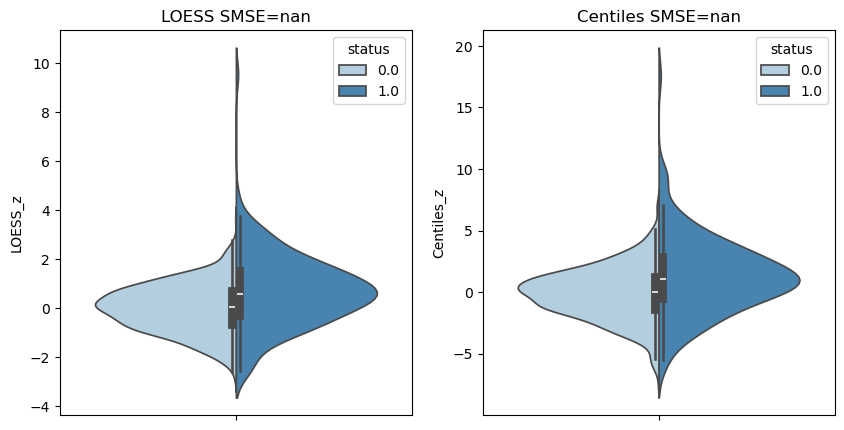

In [61]:
# Plot the residuals of the model (actual value - predicted value)
m_gap2.plot_res()

# Plot the z-scores of the model (model residuals / std deviation)
m_gap2.plot_z()

### Case-control
Finally, we'll return to our example from tutorial 0. As we saw before, a case-control on the raw scores returns no significant difference. However, when we use the deviance scores from the model the results are clearly significant - this indicates that the normative model captures information that the simple group average doesn't. Great news!

In [63]:
# Function to perform statistical analysis using Ordinary ELast Squares (OLS) analysis
# See Tutorial 0 for full breakdown of the function's parameters
def case_control(df, group='status', score='score'):
    dmat = pat.dmatrix('C({})'.format(group), df, return_type='dataframe', NA_action='raise')
    results = sm.OLS(df[score], dmat).fit()
    return results.pvalues.iloc[1]

In [70]:
# Compare uncorrected p-values (group-level stats) to centiles and LOESS model z-scores p-values
# Why doing the linear model on z-scores and not residuals? Because Z-scores provide a scale-invariant 
# comparison of how far observations deviate from the mean of each model (LOESS or Centiles). 
# This makes it easier to assess the significance of these deviations in distinguishing between groups 
# (e.g., case vs. control) compared to using raw residuals, which might have different scales or distributions.

p_uncorrected = case_control(m_fine.data, score='score')
p_centiles = case_control(m_fine.data, score='Centiles_z')
p_loess = case_control(m_fine.data, score='LOESS_z')

print('Uncorrected: p =', p_uncorrected)
print('Centiles: p =', p_centiles)
print('LOESS: p =', p_loess)

Uncorrected: p = 0.8760719899903959
Centiles: p = 1.8618848984171572e-08
LOESS: p = 9.040137737057033e-11


### Full LOESS & Centiles Outputs
We can explore the full outputs of the LOESS & Centiles models by accessing the data attribute of the PyNM object. In general, all model outputs will be added as columns to the PyNM dataframe or as attributes to the PyNM object.

In [67]:
m_fine.data.head()

,age,status,score,LOESS_pred,LOESS_sigma,LOESS_residuals,LOESS_z,LOESS_rank,Centiles,Centiles_5,Centiles_32,Centiles_pred,Centiles_68,Centiles_95,Centiles_sigma,Centiles_residuals,Centiles_z,Centiles_rank
0,1.174205,0.0,1.733340,1.132623,0.976977,0.600717,0.614873,0.0,24.0,0.171941,2.027151,2.563348,3.131734,4.884151,0.552292,-0.830008,-1.502843,-2.0
1,1.329895,1.0,0.201192,1.132623,0.976977,-0.931431,-0.953381,0.0,6.0,0.171941,2.027151,2.563348,3.131734,4.884151,0.552292,-2.362156,-4.277007,-2.0
2,1.390878,0.0,2.098539,1.132623,0.976977,0.965915,0.988677,0.0,38.0,0.171941,2.027151,2.563348,3.131734,4.884151,0.552292,-0.464809,-0.841601,-2.0
3,1.418167,0.0,0.034777,1.132623,0.976977,-1.097846,-1.123717,-1.0,5.0,0.171941,2.027151,2.563348,3.131734,4.884151,0.552292,-2.528571,-4.578324,-2.0
4,1.436357,0.0,0.509641,1.132623,0.976977,-0.622982,-0.637663,0.0,9.0,0.171941,2.027151,2.563348,3.131734,4.884151,0.552292,-2.053707,-3.718517,-2.0


### Description of columns
All values for the LOESS & Centiles models are from the bin whose center is closest to a given subject.

- age
    - From the input dataframe.
- status
    - From the input dataframe.
- score
    - From the input dataframe.
- LOESS_pred
    - Prediction of the LOESS model.
- LOESS_sigma
    - Standard deviation of the LOESS model.
- LOESS_residuals
    - Difference between actual value of score and LOESS_pred.
- LOESS_z
    - LOESS_residuals / LOESS_sigma.
- LOESS_rank
    - Rank of subject based on LOESS_z.
- Centiles
    - The centile of each subject's score.
- Centiles_5
    - 5% confidence interval for the Centiles model (centile 95).
- Centiles_32
    - Lower estimate of std for the Centiles model (centile 32) assuming gaussian noise.
- Centiles_pred
    - Prediction of the Centiles model (centile 50).
- Centiles_68
    - Upper estimate of std for the Centiles model (centile 68) assuming gaussian noise.
- Centiles_95
    - 95% confidence interval for the Centiles model (centile 95).
- Centiles_sigma
    - Standard deviation of the Centiles model, estimated as (centile 68 - centile 32)/2 assuming gaussian noise.
- Centiles_residuals
    - Difference between actual value of score and Centiles_pred.
- Centiles_z
    - Centiles_residuals / Centiles_sigma
- Centiles_rank
    - Rank of subject based on Centiles_pred.

### Summary

- The basic format of normative modeling is to fit a model on the controls (or a subset of) and then predict using the rest of the dataset
- To use PyNM all we need is a dataframe with columns for group, score and confound(s)
- The LOESS & Centiles models work by splitting the dataset into bins and estimating a model in each
- We can adjust the model fit by changing the bin_width and bin_spacing parameters
- The LOESS & Centiles models do not handle missing data well
- Normative modeling captures information that case-control analysis doesn't
- We can access the full output of all the models using the data attribute of the PyNM object


### Resources

Example of use of the LOESS approach:

- Lefebvre et al. Front. Neurosci. 2018, Alpha Waves as a Neuromarker of Autism Spectrum Disorder: The Challenge of Reproducibility and Heterogeneity
- Maruani et al. Front. Psychiatry 2019, Morning Plasma Melatonin Differences in Autism: Beyond the Impact of Pineal Gland Volume

For the Centiles approach see:

- Bethlehem et al. Communications Biology 2020, A normative modelling approach reveals age-atypical cortical thickness in a subgroup of males with autism spectrum disorder